# Imports

In [141]:
import pandas as pd 
import numpy as np
import os
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Parameters

In [142]:
bout_frames = 75
dst_dir = "./Data/Processed"
num_clusters = 8

# Import CSVS

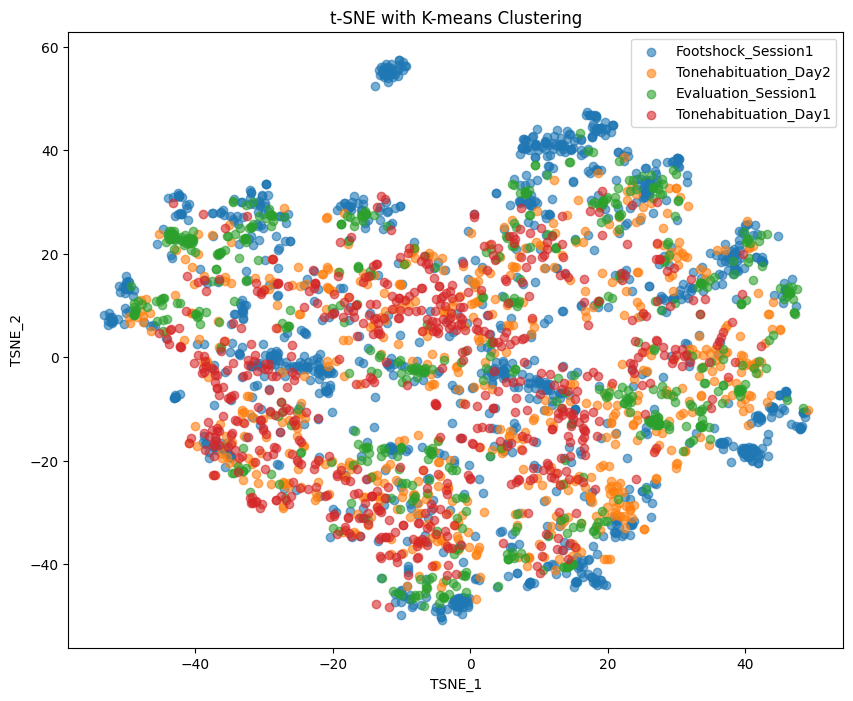

In [143]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd

# Define the number of frames per bout
bout_frames = 75

# Collect all trial folders
trials = [os.path.join(dst_dir, f) for f in os.listdir(dst_dir) if os.path.isdir(os.path.join(dst_dir, f))]
folders = [
    [os.path.join(trial, f) for f in os.listdir(trial) if os.path.isdir(os.path.join(trial, f))]
    for trial in trials
]

# Read CSV files into DataFrames
dfs = [
    [pd.read_csv(os.path.join(folder, filename), index_col=0)
     for folder in trial
     for filename in os.listdir(folder)
     if "pose_void_tone_shock_combined" in filename]
    for trial in folders
]

# Prepare t-SNE segments and video ends
tsne_segments, video_ends = [], []
last_end = 0

for trial_dfs in dfs:
    trial_video_ends = []
    for i, df in enumerate(trial_dfs):
        # Retain only rows that fit into complete 75-frame bouts
        total_frames = len(df)
        complete_bouts = total_frames // bout_frames
        cutoff_frames = complete_bouts * bout_frames
        trial_dfs[i] = df.iloc[:cutoff_frames].reset_index(drop=True)
        
        trial_dfs[i]['Group'] = trial_dfs[i].index // bout_frames
        df_xy = trial_dfs[i].filter(regex='(_x|_y)$')
        new_values = df_xy.values.reshape(-1, len(df_xy.columns) * bout_frames)
        tsne_segments.append(new_values)
        trial_video_ends.append(last_end + len(new_values))
        last_end = trial_video_ends[-1]
    video_ends.append(trial_video_ends)

# Stack t-SNE input and perform t-SNE and K-means clustering
tsne_input = np.vstack(tsne_segments)
tsne_results = TSNE(n_components=2, perplexity=30, method='barnes_hut', random_state=42).fit_transform(tsne_input)
kmeans_labels = KMeans(n_clusters=8, random_state=42).fit_predict(tsne_results)

# Create DataFrame for t-SNE results and assign cluster labels
tsne_df = pd.DataFrame(tsne_results, columns=['TSNE_1', 'TSNE_2'])
tsne_df['Cluster'] = kmeans_labels

# Assign Trial and Video labels
previous_end = 0
for trial_name, trial in zip(trials, video_ends):
    trial_name_short = trial_name.split('/')[-1]
    tsne_df.loc[previous_end:trial[-1], 'Trial'] = trial_name_short
    previous_end = trial[-1]

previous_end = 0
for i, (trial_videos, trial_folders) in enumerate(zip(video_ends, folders)):
    for video_end, folder in zip(trial_videos, trial_folders):
        tsne_df.loc[previous_end:video_end, 'Video'] = folder.split('/')[-1]
        previous_end = video_end

# Plot t-SNE results with clustering
plt.figure(figsize=(10, 8))
for trial in tsne_df['Trial'].unique():
    cluster_data = tsne_df[tsne_df['Trial'] == trial]
    plt.scatter(cluster_data['TSNE_1'], cluster_data['TSNE_2'], label=trial, alpha=0.6)

plt.xlabel('TSNE_1')
plt.ylabel('TSNE_2')
plt.title('t-SNE with K-means Clustering')
plt.legend()
plt.show()


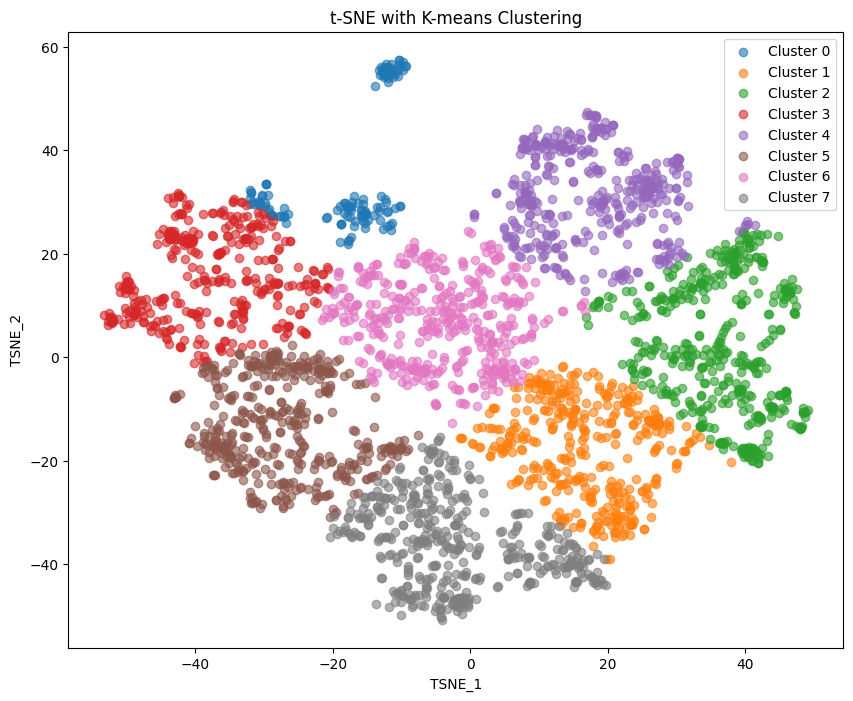

In [144]:
plt.figure(figsize=(10, 8))
for cluster in range(num_clusters):
    cluster_data = tsne_df[tsne_df['Cluster'] == cluster]
    plt.scatter(cluster_data['TSNE_1'], cluster_data['TSNE_2'], label=f'Cluster {cluster}', alpha=0.6)

plt.xlabel('TSNE_1')
plt.ylabel('TSNE_2')
plt.title('t-SNE with K-means Clustering')
plt.legend()
plt.show()

In [159]:
# Add cluster and trial information to video DataFrames
for trial_dfs, (trial, cluster_df) in zip(dfs, tsne_df.groupby('Trial', sort=False)):
    for video, (video_name, video_df) in zip(trial_dfs, cluster_df.groupby('Video', sort=False)):
        video["Cluster"] = np.repeat(video_df['Cluster'].values, bout_frames)
        video["Video"] = video_name
        video["Trial"] = trial

# Function to save video data to CSV
def save_videos(trials, base_dir, condensed=False, frame_step=75, frame_multiplier=300):
    for trial in trials:
        for video in trial:
            trial_dir = f"{base_dir}/{video['Trial'][0]}"
            file_path = f"{trial_dir}/{video['Video'][0]}.csv"
            os.makedirs(trial_dir, exist_ok=True)
            
            if condensed:
                temp = video.iloc[::frame_step].copy()
                temp.reset_index(drop=True, inplace=True)
                temp["Frame"] = temp.index * frame_multiplier
                temp = temp[["Cluster", "Frame"]]
                temp.to_csv(file_path, index=False)
            else:
                video.to_csv(file_path, index=False)
            
            print(video.head())

# Save full and condensed video DataFrames
save_videos(dfs, "./Data/Clustered")
save_videos(dfs, "./Data/Clustered_Condensed", condensed=True)

# Group and aggregate video DataFrames, then create a heatmap DataFrame
grouped_dfs = [
    video.groupby(['Group', 'Trial', 'Video'], as_index=False).agg({
        'Is_Voiding': 'max',
        'Shock_Start': 'max',
        'Shock_End': 'max',
        'Tone_Start': 'max',
        'Tone_End': 'max',
        'Seconds': 'mean',
        'Cluster': 'mean'
    }).assign(Index=lambda x: x.index)
    for i, trial in enumerate(dfs) for video in trial
]


combined_df = pd.concat(grouped_dfs, ignore_index=True)
combined_df['Trial_Video'] = combined_df['Trial'] + " - " + combined_df['Video']

heatmap_data = combined_df.pivot_table(
    index='Trial_Video',  # Combined Trial and Video as the row index
    columns='Group',      # Group as the x-axis
    values='Cluster',     # Cluster value for the heatmap
    aggfunc='mean'        # Aggregating by mean (or other suitable method)
).fillna(0)  # Fill missing values with 0 if necessary

   RightEar_x  RightEar_y  RightEar_likelihood  LeftEar_x  LeftEar_y  \
0   335.15700   721.53260             0.783202  348.04355  668.34580   
1   384.32095   683.62274             0.886905  389.65870  627.84590   
2   395.04280   674.37480             0.741842  391.58167  616.14136   
3   405.74155   670.28000             0.875650  403.26187  611.96906   
4   419.98615   665.46704             0.842396  421.38992  607.61383   

   LeftEar_likelihood  forehead_x  forehead_y  forehead_likelihood     Nose_x  \
0            0.826553   368.69882   705.29987             0.788175  423.06128   
1            0.817989   419.46893   653.42566             0.767218  479.28796   
2            0.743235   426.59106   637.64166             0.794606  485.93506   
3            0.694349   437.77322   637.09155             0.822523  491.86258   
4            0.638788   451.97327   628.15936             0.700834  511.20540   

   ...       Seconds  Is_Voiding  Shock_Start  Shock_End  Tone_Start  \
0  ...  

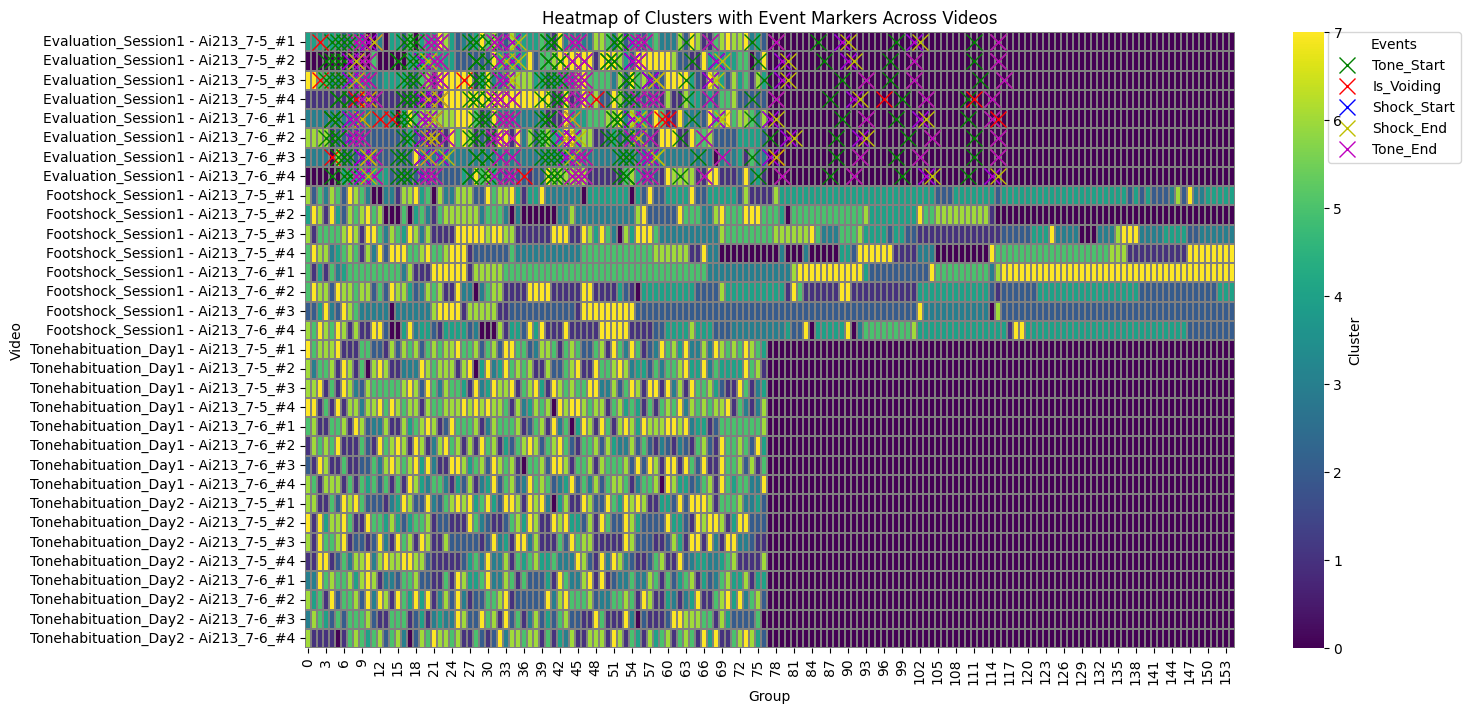

In [ ]:
plt.figure(figsize=(15, 8))

ax = sns.heatmap(
    heatmap_data, 
    cmap='viridis', 
    linewidths=0.1, 
    linecolor='gray', 
    cbar_kws={'label': 'Cluster'}
)

for _, row in combined_df.iterrows():
    # Get the row index for the combined Trial and Video
    trial_video_idx = heatmap_data.index.tolist().index(row['Trial_Video'])
    group = row['Group']  # Get the group (x-axis)
    
    # Add 'X' markers at the respective trial-video and group positions
    if row['Is_Voiding']:
        ax.plot(group + 0.5, trial_video_idx + 0.5, 'rx', markersize=12, label='Is_Voiding')
    if row['Shock_Start']:
        ax.plot(group + 0.5, trial_video_idx + 0.5, 'bx', markersize=12, label='Shock_Start')
    if row['Shock_End']:
        ax.plot(group + 0.5, trial_video_idx + 0.5, 'yx', markersize=12, label='Shock_End')
    if row['Tone_Start']:
        ax.plot(group + 0.5, trial_video_idx + 0.5, 'gx', markersize=12, label='Tone_Start')
    if row['Tone_End']:
        ax.plot(group + 0.5, trial_video_idx + 0.5, 'mx', markersize=12, label='Tone_End')

handles, labels = ax.get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))

ax.legend(
    unique_labels.values(), 
    unique_labels.keys(), 
    bbox_to_anchor=(1.10, 1),  
    loc='upper left', 
    borderaxespad=0, 
    title='Events'
)
# Adjust labels and title
plt.xlabel('Group')
plt.ylabel('Trial - Video')
plt.title('Heatmap of Clusters with Event Markers Across Trial and Video')
plt.show()


In [ ]:
# dfs_list = []
# for trial, trial_dfs in enumerate(dfs):
#     # print(len(trial_dfs))
#     for i, df in enumerate(trial_dfs):
#         df['Trial'] = f'Trial {trial+1}'
#         df['Video'] = f'Video {i+1}'
#         trial_dfs[i] = df
#         dfs_list.append(df)
# combined_df = pd.concat(dfs_list, ignore_index=True)

In [ ]:
# import glob
# video_dataframes = [group.iloc[::75].reset_index(drop=True) for _, group in combined_df.groupby(['Video', 'Trial'])]
# names = [os.path.basename(x) for x in glob.glob("../Footshock_Session1_Fixed/*")]

# for df, name in zip(video_dataframes, names):
#     df['frame'] = df.index * 75 * 8
#     df = df[["Cluster", "Video", "Seconds", "frame"]]
#     df.to_csv(f"../ClusterOutput/Footshock_Session1/{name}.csv")

In [ ]:
# len(video_dataframes)

32

In [ ]:
# video

,RightEar_x,RightEar_y,RightEar_likelihood,LeftEar_x,LeftEar_y,LeftEar_likelihood,forehead_x,forehead_y,forehead_likelihood,Nose_x,...,Seconds,Is_Voiding,Shock_Start,Shock_End,Tone_Start,Tone_End,Group,Cluster,Video,Trial
0,688.75650,621.92480,0.715536,660.27180,578.82190,1.000000,699.36410,592.70447,0.593413,762.45560,...,6.183138e+07,False,False,False,False,False,0,7,Video 8,Trial 4
1,685.45850,593.25820,0.754507,649.94520,557.15186,0.981023,684.43740,566.31150,0.669346,759.31177,...,6.183148e+07,False,False,False,False,False,0,7,Video 8,Trial 4
2,683.69560,635.30255,0.833018,605.48486,600.58400,0.631705,651.99920,623.89453,0.717086,656.85846,...,6.183159e+07,False,False,False,False,False,0,7,Video 8,Trial 4
3,677.65610,639.05835,0.979874,621.40700,615.42020,0.459772,646.16830,629.63100,0.764176,674.66504,...,6.183170e+07,False,False,False,False,False,0,7,Video 8,Trial 4
4,632.46260,592.06903,0.314191,588.37130,591.88477,0.255843,619.42600,598.71220,0.340190,668.75770,...,6.183179e+07,False,False,False,False,False,0,7,Video 8,Trial 4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5770,505.45844,532.23346,0.790787,520.98240,507.76135,0.973748,530.90850,556.96940,1.000000,536.72970,...,6.242440e+07,False,False,False,False,False,76,6,Video 8,Trial 4
5771,506.02030,534.19420,0.814778,522.09760,509.26500,0.913064,531.60815,557.56710,0.984904,537.69650,...,6.242450e+07,False,False,False,False,False,76,6,Video 8,Trial 4
5772,506.98236,540.68430,0.706734,520.69340,509.77240,1.000000,529.22770,560.71810,0.988872,534.57300,...,6.242460e+07,False,False,False,False,False,76,6,Video 8,Trial 4
5773,508.68924,535.98663,0.781320,521.80475,502.78540,1.000000,529.07526,552.82680,0.916622,530.80250,...,6.242469e+07,False,False,False,False,False,76,6,Video 8,Trial 4


In [ ]:
# filtered_df = combined_df[(combined_df['Cluster'] == 19)]

In [ ]:
# grouped = filtered_df.groupby(['Video', 'Group'])

# # Get the maximum number of frames (rows) in the largest group+video combination
# max_frames = max([len(group) for _, group in grouped])
# images = []

# # Iterate over each frame index
# for frame_index in range(max_frames):
#     plt.figure(figsize=(8, 6))

#     for (video, group), group_df in grouped:
#         # Ensure that the group has enough frames (rows)
#         if frame_index < len(group_df):
#             frame = group_df.iloc[frame_index]

#             # Extract (x, y) coordinates
#             right_ear_x, right_ear_y = frame['RightEar_x'], frame['RightEar_y']
#             left_ear_x, left_ear_y = frame['LeftEar_x'], frame['LeftEar_y']
#             forehead_x, forehead_y = frame['forehead_x'], frame['forehead_y']
#             nose_x, nose_y = frame['Nose_x'], frame['Nose_y']

#             # Create a scatter plot for the frame
#             plt.scatter([forehead_x], 
#                         [forehead_y],
#                         c=["Red"])

#     # Set plot title and labels
#     plt.title(f'Video: {video}, Group: {group}, Frame: {frame_index + 1}')
#     plt.xlabel('X-coordinate')
#     plt.ylabel('Y-coordinate')
#     plt.grid(True)

#     image_path = f"./temp/frame_{frame_index}.png"
#     plt.savefig(image_path)
#     images.append(image_path)
